In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


     |████████████████████████████████| 1.1MB 16.9MB/s 


# 16.1 Char-RNN을 사용해 셰익스피어 문체 생성하기

* Char-RNN을 사용해 한 번에 한 글자씩 새로운 텍스트를 생성할 수 있다.

## 16.1.1 훈련 데이터셋 만들기

In [2]:
#셰익스피어 작품을 다운로드
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [4]:
#Tokenizer클래스를 이용한 모든 글자를 정수로 인코딩
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [5]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [6]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [7]:
max_id = len(tokenizer.word_index)
print(max_id)
dataset_size = tokenizer.document_count
print(dataset_size)

39
1115394


* 케라스의 Tokenizer 클래스를 사용
 - 이 클래스의 객체를 텍스트에 훈련해야 한다. 텍스트에서 사요되는 모든 글자를 찾아 각기 다른 글자 1D에 매핑한다.
 - 이 1D는 1부터 시작해서 고유한 글자 개수까지 만들어진다.
 - char_level=True로 지정하여 단어 수준 인코딩 대신 글자 수준 인코딩을 만든다.
 - 이 클래스는 기본적으로 텍스트를 소문자로 바꾼다.(싫으면 lower=False)

In [8]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

* 전체 텍스트를 인코딩하여 각 글자를 1D로 나타낸다. (1 ~ 39가 아닌 0 ~ 38까지 ID를 얻기 위해 1을 뺀다)

## 16.1.2 순차 데이터셋을 나누는 방법

* 훈련 세트, 검증 세트, 테스트 세트가 중복되지 않도록 만드는 것이 중요하다.
 - 두 세트 사이에 문장이 걸치지 않고 완전히 분리될 수 있도록 세트 사이에 간격을 두는 것도 좋은 생각
 - 시계열을 다룰 때는 보통 시간에 따라 나눈다.
   - 시계열 데이타가 과거에서 학습하는 패턴이 미래에도 등장한다고 가정한다. 즉 변하지 않는다고 가정한다.
   - 모델이 검증 세트 마지막보다 첫 부분에서 성능이 더 좋다면 이 시계열은 충분히 안정되지 않는 것이다. 이럴 때는 짧은 시간 간격으로 모델을 훈련하는 것이 좋다.
 

In [9]:
#텍스트의 90%를 훈련세트로 사용
train_size = dataset_size * 90 //100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

## 16.1.3 순차 데이터를 윈도 여러 개로 자르기

* 훈련 세트는 백만 개 이상 글자로 이루어진 시퀀스 하나이다. 여기에 신경망을 직접 훈련시킬 수 없다.
* 이 RNN은 백만 개의 층이 있는 심층 신경망과 비슷하고 샘플 하나로 훈련하는 셈이 된다.
* 대신 데이터셋의 window()메서드를 사용해 이 긴 시퀀스를 작은 많은 텍스트 윈도로 변환한다.
 - 이 데이터셋의 각 샘플은 전체 텍스트에서 매우 짧은 부분 문자열이다.
 - RNN은 이 부분 문자열 길이만큼만 역전파를 위해 펼쳐진다.
 - 이를 TBPTT(Truncated Backpropagation Through Time)라고 한다.

In [10]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [11]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

 - window() 메서드는 각각 하나의 데이터셋으로 표현되는 윈도를 포함하는 데이터셋을 만든다.
 - 리스트의 리스트와 비슷한 중첩 데이터셋(Nested Dataset)
 - 모델은 데이터셋이 아니라 텐서를 기다해가 때문에 훈련에 중첩 데이터셋을 바로 사용할 수 없다.
 - 따라서 중첩 데이터셋을 플랫 데이터셋(Flat Dataset)으로 변환하는 flat_map()메서드를 호출해야 한다.
 - flat_map()메서드는 중첩 데이터셋을 평행하게 만들기 전에 각 데이터셋에 적용할 변환 함수를 매개변수로 받을 수 있다.

In [12]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

 - 윈도 마다 batch를 호출한다.
 - 이 길이는 윈도 길이와 같이 때문에 하나를 담은 데이터셋을 얻는다.
 - 경사 하강법은 훈련 세트 샘플이 동일 독립 분포일 때 가장 잘 작동하기 때문에 윈도를 섞는다.
 - 그 다음 윈도를 배치로 만들고 입력(처음 100개의 글자)과 타깃(마지막 글자)을 분리

In [13]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

* 일반적으로 범주형 입력 특성은 원-핫 벡터나 임베딩으로 인코딩되어야 한다.

In [14]:
dataset = dataset.prefetch(1)

* 프리패칭

In [15]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## 16.1.4 Char-RNN 모댈 만들고 훈련하기

In [16]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 368s 12ms/step - loss: 1.6220
Epoch 2/10
31370/31370 [==============================] - 365s 12ms/step - loss: 1.5340
Epoch 3/10
31370/31370 [==============================] - 365s 12ms/step - loss: 1.5123
Epoch 4/10
31370/31370 [==============================] - 368s 12ms/step - loss: 1.5005
Epoch 5/10
31370/31370 [==============================] - 364s 12ms/step - loss: 1.4934
Epoch 6/10
31370/31370 [==============================] - 361s 12ms/step - loss: 1.4882
Epoch 7/10
31370/31370 [==============================] - 361s 12ms/step - loss: 1.4844
Epoch 8/10
31370/31370 [==============================] - 359s 11ms/step - loss: 1.4814
Epoch 9/10
31370/31370 [==============================] - 362s 12ms/step - loss: 1.4787
Epoch 10/10
31370/31370 [==============================] - 361s 12ms/step - loss: 1.4764


* 이전 글자 100개를 기반으로 다음 글자를 예측하기 위해 유닛 128개를 가진 GRU 층 2개와 입력과 은닉 상태에 20% 드롭아웃을 사용한다.
* 출력층은 TimeDistributed 클래스를 적용한 Dense 층
 - 텍스트에 있는 고유한 글자 수는 39개 이므로, 이 층은 39개의 유닛을 가진다.
 - 각 글자에 대한 확률을 출력할 수 있다.
 - 타임 스텝에서 출력 확률의 합은 1이어야 하므로 Dense층의 출력에 스프트맥스 함수를 적용한다.
* "sparse_categorical_crossentropy" 손실과 Adam 옵티마이저를 사용해 모델의 compile()메서드를 호출

## 16.1.5 Char-RNN 모델 사용하기

* 셰익스피어가 쓴 텍스트에서 다음 글자를 예측하는 모델
* 이 모델에 새로운 텍스트를 주입하려면 앞에서와 같이 먼저 전처리를 해야 한다.

In [17]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts))-1
    return tf.one_hot(X, max_id)

In [18]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'u'

## 16.1.6 가짜 셰익스피어 텍스트를 생성하기

In [19]:
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0]])

In [20]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

* 위와 같은 방식은 같은 단어가 계속 반복되는 경우가 많다.
* 대신 텐서플로의 tf.random.categorical()함수를 사용해 모델이 추정한 확률을 기반으로 다음 글자를 무작위로 선택할 수 있다.
 - categorical()함수는 클래스의 로그 확률(로짓)을 전달하면 랜덤하게 클래스 인덱스를 샘플링한다.
 - 생성된 텍스트의 다양성을 더 많이 제어하려면 온도(Temperature)라 불리는 숫자로 로짓을 나눈다.
 - 온도는 원하는 값으로 설정할 수 있는데, 0에 가까울수록 높은 확률을 가진 글자를 선택한다.
 - 온도가 매우 높으면 모든 글자가 동일한 확률을 가진다.

In [21]:
next_char("How are yo", temperature=1)

'u'

In [22]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [23]:
print(complete_text("t", temperature=0.2), end="\n\n")
print(complete_text("t", temperature=1), end="\n\n")
print(complete_text("t", temperature=2))

the worst and the belly and the belly stand you who

tio:
ay 't so partic, rise your honour, but thirmen

t lvce? t?goo, hire revals dear. ruli-faeern'd hand


## 16.1.7 상태가 있는 RNN

* 상태가 없는 RNN
 - 훈련 반복마다 모델의 은닉 상태를 0으로 초기화
 - 타임 스텝마다 이 상태를 업데이트하고 마지막 타임 스텝후에는 더 필요가 없기 때문에 버린다.
* RNN이 한 훈련 배치를 처리한 후 마지막 상태를 다음 훈련 배치의 초기 상태로 사용한다면?
* 이를 상태가 있는 RNN이라고 한다.
 - 역전파는 짧은 시퀀스에서 일어나지만 모델이 장기간 패턴을 학습할 수 있다.

In [24]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [25]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

* 상태가 있는 RNN은 배치에 있는 각 입력 시퀀스가 이전 배치의 시퀀스가 끝난 지점에서 시작
 - 따라서 순차적이고 겹치지 않는 입력 시퀀스를 만든다.
 - Dataset을 만들 때 window()메서드에서 shift=n_steps를 사용한다.
 - 셰익스피어의 텍스트를 길이가 동일한 32개의 텍스트로 나누고 각 텍스트에 대해 연속적인 입력 시퀀스를 가진 데이터 셋으 하나 만든다.
 - tf.train.Dataset.zip(datasets).map(lambda*windows: tf.stack(windows))를 사용해 연속직인 배치를 만든다.
 - 여기에서 한 배치에서 n번째 입력 시퀀스의 시작은 정확히 이전 배치의 n번째 입력 시퀀스가 끝나는 지점이다.

In [26]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, #recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [27]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 4s 12ms/step - loss: 2.6296
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 2.2407
Epoch 3/50
313/313 [==============================] - 4s 11ms/step - loss: 2.1121
Epoch 4/50
313/313 [==============================] - 4s 11ms/step - loss: 2.0363
Epoch 5/50
313/313 [==============================] - 4s 11ms/step - loss: 1.9855
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9478
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9188
Epoch 8/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8968
Epoch 9/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8777
Epoch 10/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8647
Epoch 11/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8510
Epoch 12/50
313/313 [==============================] - 4s 12ms/step - loss: 1.8399
Epoch 13/50
3

# 16.2 감성 분석

## IMDb 리뷰 데이터셋
 - 영어로 쓰인 영화 리뷰 50,000개로 구성
 - 유명한 인터넷 영화 데이터 베이스에서 추출한 것으로 각 리뷰가 긍정적인지 부정적인지 나타내닌 이진 타깃 포함

In [29]:
#이미 전처리 되어 있는 데이터셋
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()
X_train[0][:10]

17465344/17464789 [==============================] - 0s 0us/step


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

* X_train은 리뷰들의 리스트
 - 각 리뷰는 넘파이 정수 배열로 표현
 - 각 정수는 하나의 단어
 - 구두점을 모두 제거하고 단어는 소문자로 변환한 다음 공백으로 나누어 빈도에 따라 인덱스르르 붙인다.
 - 정수 0, 1, 2는 각각 패딩 토큰, SOS(Start-Of-Sequence), 알 수 없는 단어

In [30]:
#디코딩
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

* 공백을 사용해 단어 경계를 구분
* 하지만 모든 언어가 이런 식으로 공백을 사용하진 않기 때문에 제한이 많고 항상 최선의 방버이 아니다.
* 그래서 더 좋은 방법으로 단어(Subword)수준으로 텍스트를 토큰화하거나 복원하는 비지도 학습 방법이 있다.
 - 공백을 하나의 문자로 취급하기 때문에 언어 독립적
 - 모델이 이전에 본 적이 없는 단어를 만나더라도 의미를 추측할 수 있다.
* 다른 방법으로는 부분 단어를 인코딩하는 방법도 있다.

In [31]:
# 전처리를 모델 자치에 포함
import tensorflow_datasets as tfds
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
datasets.keys()

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGO6NGG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGO6NGG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGO6NGG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


dict_keys(['test', 'train', 'unsupervised'])

In [32]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples
train_size, test_size

(25000, 25000)

In [33]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [34]:
# 전처리 함수
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [35]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

* 전처리 함수
 - 리뷰 텍스트를 잘라내어 각 리뷰에서 처음 300글자만 남긴다.
 - 정규식을 사용해 <br />태그를 공백으로 바꾼다.
 - 문자와 작은 따옴표가 아닌 다른 모든 문자를 공백으로 바꾼다.
 - 리뷰는 공백으로 나눈다. 이때 래그드 텐서(ragged tensor)가 반환
 - 이 래그드 텐서를 밀집 텐서로 바꾸고 동일한 길이가 되도록 패딩 토큰 "pad" 로 모든 리뷰를 패딩

In [36]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

* 어휘 사전 구축
 - 전체 훈련 세트를 한 번 순회하면서 preprocess() 함수를 적용하고 Counter로 단어의 등장 횟수를 센다.

In [37]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [38]:
len(vocabulary)

53893

In [39]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

* 어휘 사전 중에서 가장 많이 등장하는 단어 10,000개만 남기고 삭제

In [40]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

* 각 단어를 ID로 바꾸는 전처리 단계
 - 1,000 개의 oov 버킷을 사용하는 룩업 테이블을 만든다.

In [41]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [42]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

* 리뷰를 배치로 묶고 preprocess()함수를 사용해 단어의 짧은 시퀀스로 바꾼다.
* 앞서 만든 테이블을 사용하는 encode_words() 함수로 단어를 인코딩한다.
* 다음 배치를 프리페치한다.

In [43]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 24s 31ms/step - loss: 0.5377 - accuracy: 0.7217
Epoch 2/5
781/781 [==============================] - 24s 30ms/step - loss: 0.3482 - accuracy: 0.8553
Epoch 3/5
781/781 [==============================] - 24s 30ms/step - loss: 0.1880 - accuracy: 0.9357
Epoch 4/5
781/781 [==============================] - 23s 30ms/step - loss: 0.1235 - accuracy: 0.9573
Epoch 5/5
781/781 [==============================] - 23s 30ms/step - loss: 0.1081 - accuracy: 0.9604


* 모델 훈련
 - 첫 번째 층은 단어 ID를 임베딩으로 변환하는 Embedding층
   - 임베딩 행렬은 단어 ID당(vocab_size + num_oov_buckets) 하나의 행과 임베딩 차원당 하나의 열을 가진다.
 - 모델의 입력은 [배치크기, 타임 스텝 수] 크기를 가진 2D 텐서이지만 Embedding 층의 출력은 [배치 크기, 타임 스텝수, 임베딩 크기] 크기를 가진 3D 텐서가 된다.
 - 모델의 나머지 부분은 GRU 층 두개로 구성되고, 두 번째 층은 마지막 타임 스텝의 출력만 반환한다.
 - 출력층은 시그모이드 활성화 함수를 사용하는 하나의 뉴런으로, 리뷰가 영화에 대한 긍정적인 감정을 표현하는지에 대한 추정 확률을 출력한다.

## 16.2.1 마스킹

* 원래 데이터 그대로 모델이 패딩 토큰을 무시하도록 학습되어야 한다.
* 하지만 이미 무시할 토큰을 알고 있다면, 패딩 토큰을 무시하도록 모델에게 알려주어 실제 의미가 있는 데이터에 집중할 수 있게 만든다.
 - Embedding 층을 만들 때 mask_zero = True 매개변수를 추가하면 된다.
 - 구체적으로 Embedding 층이 K.not_equal(inputs, 0)와 같은 마스크 텐서를 만든다.
 - 이 텐서는 입력과 크기가 같은 불리언 텐서이다.
 - ID가 0인 위치는 False이고 나머지 True이다.
 - 일반적으로 마스킹된 타임 스텝을 무시한다.

In [44]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 23s 30ms/step - loss: 0.5373 - accuracy: 0.7226
Epoch 2/5
781/781 [==============================] - 24s 30ms/step - loss: 0.3503 - accuracy: 0.8553
Epoch 3/5
781/781 [==============================] - 23s 30ms/step - loss: 0.1905 - accuracy: 0.9321
Epoch 4/5
781/781 [==============================] - 23s 30ms/step - loss: 0.1458 - accuracy: 0.9471
Epoch 5/5
781/781 [==============================] - 23s 30ms/step - loss: 0.1126 - accuracy: 0.9602


* 마스킹 층과 마스크 자동 전파는 Sequential 모델에 가장 잘 맞는다.
* Conv1D층과 순환 층을 섞는 것과 같이 복잡한 모델에서는 항상 작동하지 않는다.

## 16.2.2 사전훈련된 임베딩 재사용하기

* 텐서플로 허브 프로젝트는 사전훈련된 모델 컴포넌트를 모델에 추가하기 쉽게 만들어준다.
* 이런 모델 컴포넌트를 모듈(Module)이라 부른다.

In [45]:
# nnlm-en-dim50 문장 임베딩 모듈 버전 1을 감성 분석 모델에 사용
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

* hub.KerasLayer 층이 주어인 URL에서 모듈을 다운로드, 이 모듈의 이름은 문자 인코더(Sentence Encoder)이다.
 - 문자열을 입력으로 받아 하나의 벡터로 인코딩
 - 내부적으로는 문자열을 파싱해서 대규모 코퍼스에서 사전훈련된 임베딩 행렬을 사용해 각 단어를 임베딩
 - 그 다음 모든 단어 임베딩의 평균을 계산. 이 결과가 문장 임베딩
* 그 다음 두 개의 Dense층을 추가해 감성 분석 모델을 만든다.

In [46]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5450 - accuracy: 0.7283
Epoch 2/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5135 - accuracy: 0.7479
Epoch 3/5
781/781 [==============================] - 4s 6ms/step - loss: 0.5087 - accuracy: 0.7518
Epoch 4/5
781/781 [==============================] - 4s 6ms/step - loss: 0.5050 - accuracy: 0.7534
Epoch 5/5
781/781 [==============================] - 4s 6ms/step - loss: 0.5021 - accuracy: 0.7563


# 16.3 신경망 기계 번역을 위한 인코더-디코더 네트워크

* 영어 문장을 인코더로 주입하면 디코더는 프랑스어 번역을 출력한다.
* 번역은 한 스텝 뒤쳐져서 디코더의 입력으로도 사용된다.
* 다르게 말하면 디코더는 이전 스텝에서 출력된 단어를 입력으로 사용한다
 - 맨 처음 단어는 SOS(Start-Of-Sequence)토큰으로 시작된다.
 - 디코더는 문장의 끝에 EOS(End-Of-Sequence)토큰이 있을 것으로 기대한다.

* 모델을 구현하기위해 처리할 것
 - 문장을 비슷한 길이의 버킷으로 그룹핑한다.
 - 버킷에 담긴 문장이 모두 동일한 길이가 되도록 패딩을 추가한다.
* EOS 토큰 이후 출력은 모두 무시한다.
 - 이 토큰들은 손실에 영향을 미치지 않는다.
* 출력 어휘 사전이 방대할 경우 모든 단어의 확률을 출력하려면 매우 느려진다.
 - 큰 벡터에서 소프트맥스 함수를 계산하는 것은 연산 비용이 매우 높다.
 - 이를 피하기 위한 한 가지 방법으로 타깃 단어에 대한 로짓과 타킷이 아닌 단어 중 무작위로 샘플링한 단어의 로짓만 고려하는 샘플링 소프트맥스(Sampled Softmax)이다.

In [47]:
vocab_size = 100
embed_size = 10

In [48]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [49]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [50]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 1s 37ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 1s 39ms/step - loss: 4.6025


* 인코더-디코더 모델
 - LSTM층을 만들 때 최종 은닉 상태를 디코더로 보내기 위해 return_state=True로 지정
 - LSTM셀을 사용하기 때문에 은닉 상태 두개(단기, 장기)를 반환
 - TrainingSampler는 각 스텝에서 디코더에게 이전 스텝의 출력이 무엇인지를 알려준다.
 - 추론 시에는 실제로 출력되는 토큰의 임베딩이 된다.
 - 훈련 시에는 이전 타깃 토큰의 임베딩이 되어야한다.
* ScheduledEmbddingTrainingSampler는 타깃과 실제 출력 사이에서 무작위로 선택하며 훈련하는 동안 점진적으로 확률을 바꿀 수 있다.

## 16.3.1 양방향 RNN

* 각 타임 스텝에서 일반적인 순환 층은 과거와 현재의 입력만 보고 출력을 생성한다.
 - 이런 종류의 RNN은 시계열을 예측할 때 적합하지만 신경망 기계 번역 같은 여러 종류의 NLP 작업에는 맞지 않는다.
 - 이런 작업은 주어진 단어를 인코딩하기 전에 다음 단어를 미리 보는 것이 좋다.
 - 이를 위해 동일한 입력에 대해 두 개의 순환 층을 실행한다.
* 양방향 순환 층(Bidirectional Recurrent Layer)
 - 하나는 왼쪽에서 오른쪽으로 단어를 읽고, 다른 하나는 오른쪽에서 왼쪽으로 읽는다.
 - 그다음 일반적으로 타임 스텝마다 이 두 출력을 연결한다.

In [51]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## 16.3.2 빔 검색

* 스텝마다 무조건 가장 가능성 있는 단어를 출력해서 최적의 번역을 만들지 못한다. 그래서 이 실수를 고치기 위해

* 빔 검색 (Beam Search)
 - k개의 가능성 있는 문장의 리스트를 유지하고, 디코더 단계마다 이 문장의 단어를 하나씩 생성하여 가능성 있는 k개의 문장을 만든다.
 - 이 파라미터 k를 빔 너비(Beam Width)라고 부른다.

# 16.4 어텐션 메커니즘

* 각 타임스텝에서(인코더에 의해 인코딩하여) 적절한 단어에 디코더가 초점을 맞추도록 하는 기술
* 입력 단어에서 번역까지 경로가 훨씬 짧아지는 것을 의미하므로 RNN의 단기 기억의 제한성에 훨씬 적은 영향을 받게 된다.
* 어텐션 메커니즘은 신경망 기계 번역에 큰 변화를 만들었고, 툭히 긴 문장에 대해서 최고 수준의 성능을 크게 향상했다.
* 모델 구조
 - 인코더의 마지막 은닉 상태만 디코더에 보내는 것이 아니라 인코더의 모든 출력을 디코더로 전송한다.
 - 각 타임 스텝에서 디코더의 메모리 셀은 이런 모든 인코더 출력의 가중치 합을 전송한다.
 - 이 단계에서 주의를 집중할 단어를 결정한다.
 - 디코더의 나머지 부분은 앞서 본 것과 동일하게 작동한다.
 - 타임 스텝마다 메모리 셀이 앞서 언급한 입력과 이전 타임 스텝의 은닉 상태를 받는다.
 - 마지막으로 이전 타임 스텝에서 타깃 단어를 받는다.

* 가중치는 어디에서 오는가?
 - 정렬 모델(Alignment Model) 또는 어텐션 층 이라 부르는 작은 신경망에 의해 생성된다.
 - 이 모델은 인코더-디코너 모델의 나머지 부분과 함께 훈련된다.
 - TimeDistributed 클래스를 적용한 Dense층으로 시작
 - 이 층은 하나의 뉴런으로 구성되고 인코더의 모든 출력을 입력으로 받아 디코더의 이전 은닉 상태를 연결한다.
 - 이 층은 각 인코더 출력에 대한 점수를 출력한다.
 - 이 점수는 각 출력이 디코더의 은닉 상태와 얼마나 잘 맞는지를 측정한다.
 - 마지막으로 모든 점수가 스포트맥스 층을 통과해 각 인코더 출력에 대한 최종 가중치를 얻는다.

* 이런 어텐션 메커니즘을 바흐다나우 어텐션(Bahdanau Attention) 또는 인코더의 출력과 디코더의 이전 은닉 상태를 연결하기 때문에 연결 어텐션(Conccatenative Attention)이라고도 부른다

* 루옹 어텐션(Luong Attention) / 곱셈 어텐션(Multiplicative Attention)

 - 인코더의 출력 하나와 디코더의 이전 은닉 상태 사이의 유사도를 측정
 - 두 벡터 사이의 점곱을 통한 유사도 측정
 - 점곱으로 하나의 점수를 만든 후, 이 점수가 소프트맥스 층을 통과해 최종 가중치를 만든다.

In [52]:
attention_mechanism = tfa.seq2seq.attention_wrapper.LoungAttention(
    units, encoder_state, memory_sequence_length = encoder_sequence_length)
attention_decoder_cell = tfa.seq2seq.attention_wrapper.AttentionWrapper(
    decoder_cell, attention_mechanism, attention_layer_size=n_units)

AttributeError: ignored

## 16.4.1 비주얼 어텐션

* 비주얼 어텐션(Visual Attention)을 사용한 이미지 캡션(Caption) 생성
 - 합성곱 신경망이 먼저 이미지를 처리하여 일련의 특성 맵을 출력
 - 어텐션 메커니즘을 장착한 디코더 RNN이 한 번에 한 단어씩 캡션을 생성
 - 디코더 타임 스텝마다 디코더는 어텐션 모델을 사용해 이미지에 적절한 부위에 초점을 맞춘다.

## 16.4.2 트랜스포머 구조 : 어텐션이 필요한 전부다

* 트랜스포머(Transfomer) 구조
 - 순환 층, 합성곱 층을 전혀 사용하지 않고 어텐션 메커니즘만 사용해 NMT문제에서 최고 수준 성능을 내는 모델
 - 왼쪽 부분은 인코더로, 앞에서와 같이 단어 ID의 시퀀스로 표현된 문장의 배치를 입력으로 받는다. 각 단어를 512차원의 표현으로 인코딩한다. 인코딩의 윗부분은 N번 반복되어 쌓아 올린다.
 - 오른쪽 부분은 디코더로, 훈련하는 동안 타깃 문장을 입력으로 받는다. 이 입력은 오른쪽으로 한 타임 스텝 이동되어 있다. 또한 인코더의 출력을 받는다. 디코더의 윗부분도 N번 반복되어 쌓아올린다. 인코더의 최종 출력이 N번의 디코더에 모두 주입된다. 앞에서와 같이 타임 스텝마다 다코더는 가능한 다음 단어에 대한 확률을 출력한다.
 - 추론 시에는 디코더에 타깃을 주입할 수 없다. 따라서 이전 타임 스텝에서 출력된 단어를 주입한다. 이 모델이 반복적으로 실행되어 매번 하나의 단어를 예측한다.
 - 모든 층은 타임 스텝에 독립적이다.
* 독립적인 처리로 어떻게 문장을 번역할 수 있는가?
 - 인코더의 멀티-헤드 어텐션(Multi-Head Attention)층은 관련이 많은 단어에 더 많은 주의를 기울이면서 각 단어와 동일한 문장에 있는 다른 단어의 관계를 인코딩한다.
 - 셀프 어텐션(Self Attention)은 문장 자기 자신에게 주의를 기울인다.
 - 위치 인코딩은(Positional Encoding)은 문장에 있는 단어의 위치를 나타내는 단순한 밀집 벡터로, n번째 위치 인코딩이 각 문장에 있는 n번째 단어의 단어 임베딩에 더해진다. 이를 통해 모델이 각 단어의 위치를 알 수 있다.

* 위치 인코딩
 - 위치 인코딩은 문장 안에 있는 단어의 위치를 인코딩한 밀집 벡터
 - 단순히 i번째 위치 인코딩이 문장에 있는 i번째 단어의 단어 임베딩에 더해진다.
 - 여러 가지 주기의 사인과 코사인 함수로 정의한 고정된 위치 인코딩을 선호했다.
 - 학습된 위치 임베딩과 동일한 성능을 내면서 임의의 긴 문장으로 확장할 수 있기 때문에 많이 사용된다.
 - 위치마다 고유한 위치 인코딩이 만들어지기 때문에 위치 인코딩을 단어 임베딩에 더하면 모델이 문장에 있는 단어의 절대 위치를 알 수 있다.
 - 진동 함수 선택에 따라 모델이 상대적인 위치도 학습할 수 있다.

In [53]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [54]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

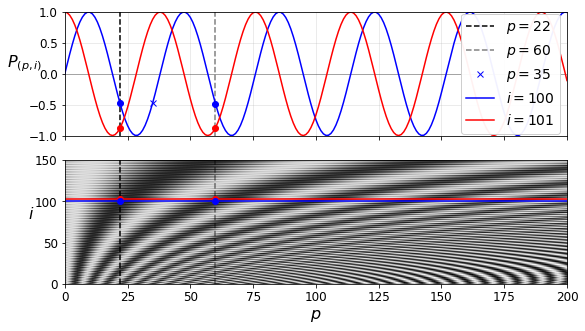

In [55]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

In [56]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

* 멀티-헤드 어텐션
 - 스케일드 점-곱 어텐션(Scaled dot-product Attention) : 인코더가 입력 문장을 분석하여 주어, 동사등을 이해하려고 한다. 인코더는 이 정보를 단어의 표현에 인코딩한다.
 - 멀티-헤드 어텐션은 스케일드 점-곱 어텐션 층의 묶음
 - 각 층은 값, 키, 쿼리의 선형 변환이 선행된다.
 - 출력은 단순히 모두 연결되어 마지막 선형 변환을 통과한다.

In [57]:
#트랜스포머 모델의 나머지 부분
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

In [62]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [63]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])